In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf, Workspace
from scalebars import *
import deconv

import balance_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
# %matplotlib notebook
%matplotlib widget
# %matplotlib qt
plt.rcParams.update({"figure.max_open_warning": 0})

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"

## TODO:
- update the synapses to enable poisson quantal input, as in the sac-sac model
- fill out notebook with figures and interactive displays

In [4]:
quanta_h5 = "/mnt/Data/prerna_velocity/static_roi_waveforms/quantum_pack.h5"
with h5.File(quanta_h5, "r") as f:
    quantum_pack = unpack_hdf(f)
    
release_rates = quantum_pack["clipped_rates"]
rec_dt = quantum_pack["rec_dt"]
target_rate_dt = 0.001  # 0.0001
bp_inputs = {("sust" if k == "PD" else "trans"): r for k, r in quantum_pack["aligned_recs"].items()}
bp_inputs["sust"] = bp_inputs["sust"] * np.max(bp_inputs["trans"]) / np.max(bp_inputs["sust"])

vrate = deconv.velocity_rate(
    bp_inputs["trans"],
    rec_dt,
    quantum_pack["quantum"],
    1,
    rf=0.06,
    spot=0.4,
    bsln_start=100,
    bsln_end=150,
    step=1,
    offset=0.,
    model_dt=target_rate_dt,
)

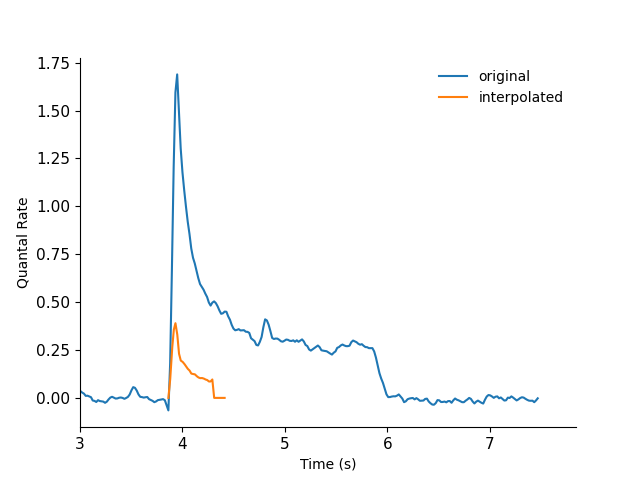

In [20]:
trans_rise = find_rise_bsln(bp_inputs["trans"], bsln_start=100, bsln_end=150, step=1) * rec_dt
rate_fig, rate_ax = plt.subplots(1)
rate_ax.plot(np.arange(len(bp_inputs["trans"])) * rec_dt, bp_inputs["trans"], label="original")
rate_ax.plot(np.arange(len(vrate)) * target_rate_dt + trans_rise, vrate, label="interpolated")
rate_ax.set_xlim(3)
rate_ax.set_xlabel("Time (s)")
rate_ax.set_ylabel("Quantal Rate")
rate_ax.legend(frameon=False)
clean_axes(rate_ax)

In [6]:
model_path = os.path.join(base_path, "model_runs")
save_name = "wip_releaser_test"
load_name = None
# load_name = "wip_releaser_test"
# load_name = "control"
# load_name = "ttx"
# load_name = "ds_ach"
# load_name = "non_ds_ach"
# load_name = "fully_non_ds_ach"


model_config = configs.sac_mode_config(ttx=False, non_ds_ach=False, offset_ampa_ach=False, plexus=0)
# model_config["synprops"]["NMDA"]["pref_prob"] = 0.0
# model_config["synprops"]["NMDA"]["null_prob"] = 0.0

model_config["sac_rate"] = vrate * 1.25
model_config["glut_rate"] = vrate * 1.25
model_config["rate_dt"] = target_rate_dt * 1000  # model is in ms

for t in ["E", "I", "NMDA", "AMPA", "PLEX"]:
    model_config["synprops"][t]["tau1"] = 0.14
    model_config["synprops"][t]["tau2"] = 0.54

# this seems pretty important to avoid inhibition missing excitation in time
# (if both are shortlived they can sawtooth too easily)
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2278860/ (ach mini)
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6772523/ (gaba mini)
model_config["synprops"]["I"]["tau2"] = 2.0
model_config["synprops"]["E"]["tau2"] = 0.3
model_config["synprops"]["NMDA"]["tau2"] = 1.0
    
base_w = 0.000313 * 3
model_config["synprops"]["E"]["weight"] = base_w
model_config["synprops"]["I"]["weight"] = base_w * 4
model_config["synprops"]["NMDA"]["weight"] = base_w * 1.33
model_config["synprops"]["PLEX"]["weight"] = base_w
    
if load_name is None:
    from ei_balance_nogui import *
    os.makedirs(model_path, exist_ok=True)
    save_path = os.path.join(model_path, save_name) + ".h5"
    load_name = save_name
    exps.sacnet_run(
        save_path,
        model_config,
        n_nets=6,
        n_trials=1,
        rho_steps=[0.0, 1.0],
        # rho_steps=[1.0],
        pool_sz=6,
    )

hdf = h5.File(os.path.join(model_path, load_name) + ".h5", "r")
d = Workspace(hdf, read_only=True)
        
rhos = list(d.keys())
idxs = list(d[rhos[0]].keys())

sac net trials 1 to 6 (of 6)...
Done!


In [7]:
def close_button():
    button = widgets.Button(description="Close Workspace")
    out = widgets.Output()

    def on_clicked(_):
        with out:
            clear_output()
            d.close()
            print("File closed!")
        
    button.on_click(on_clicked)
    return widgets.VBox([button, out])

close_button()

In [8]:
metrics = ana.get_sac_metrics(d)

dir_labels = d[rhos[0]][idxs[0]]["params"]["dir_labels"][:]
tuning = ana.analyze_tree(d, dir_labels, pref=0, thresh=-56)
sac_thetas = ana.get_sac_thetas(d)
sac_deltas = ana.get_sac_deltas(sac_thetas)

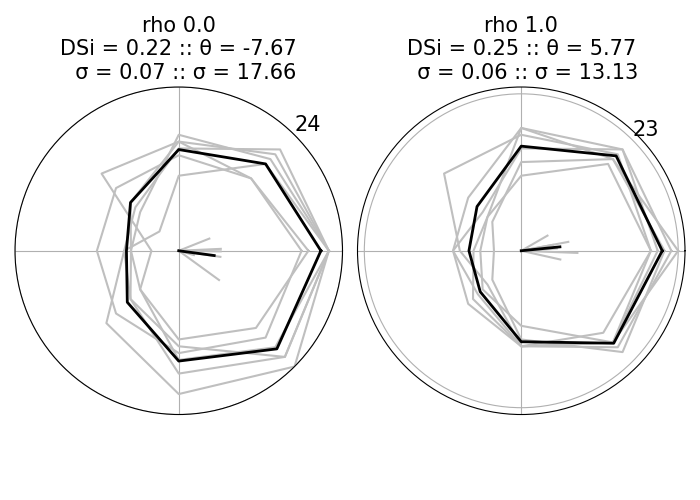

In [9]:
max_spikes = np.max([r["spikes"] for r in metrics.values()])
polar_fig = plt.figure(figsize=(7, 5))
n_cols = len(rhos)
polar_ax = [
    polar_plot(
        m,
        dir_labels,
        title="rho " + str(r),
        radius=max_spikes,
        net_shadows=False,
        save=False,
        fig=polar_fig,
        sub_loc=(1, n_cols, loc + 1),
    )
    for loc, (r, m) in enumerate(metrics.items())
]
polar_fig.tight_layout()

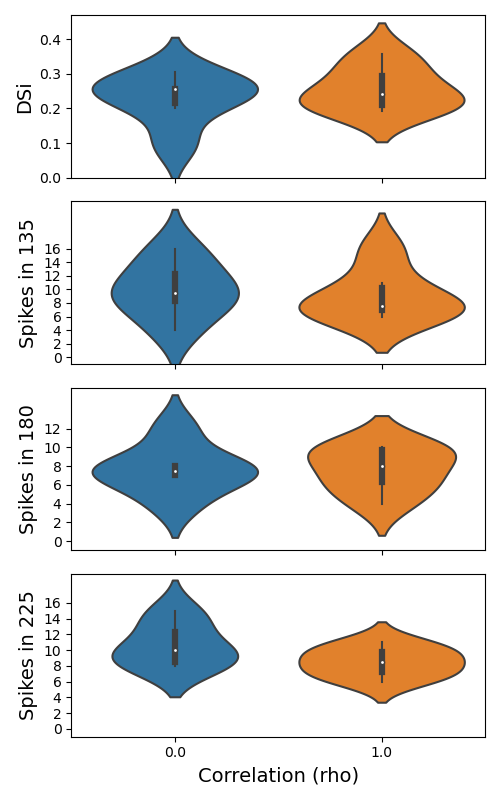

In [10]:
violins = sac_rho_violins(metrics, dir_labels, figsize=(5, 8))

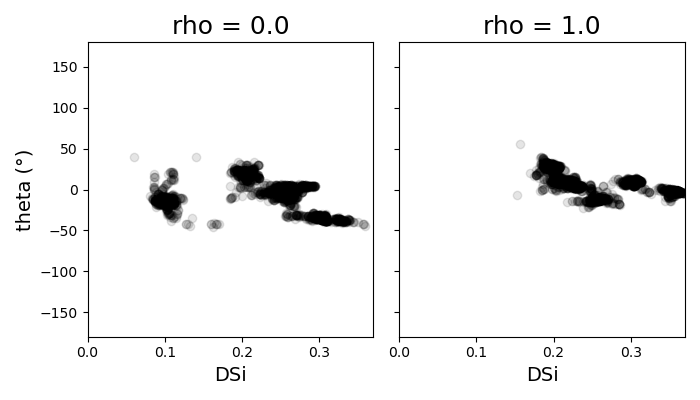

In [11]:
scatter_fig = ds_scatter(tuning, figsize=(7, 4))
scatter_fig.tight_layout()

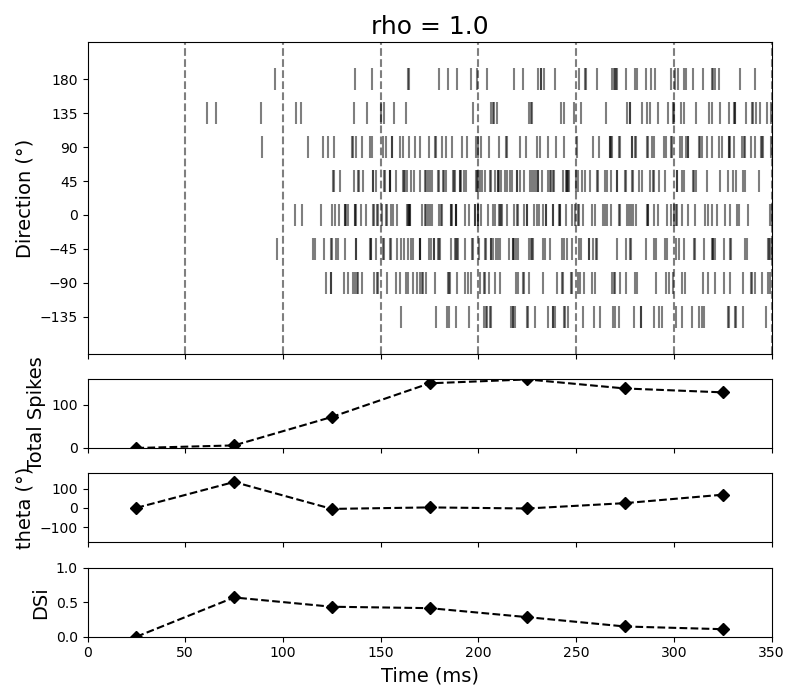

In [12]:
dir_field_offsets = [11.0, 18.8, 37.8, 13.8, 0.8, 19.3, 16.0, 0.0]  # ms
rasters_fig = spike_rasters(
    d,
    dir_labels,
    rho=1.,
    bin_ms=50,
    offsets=dir_field_offsets,
    colour="black",
    spike_vmax=160,
    figsize=(8, 7),
)

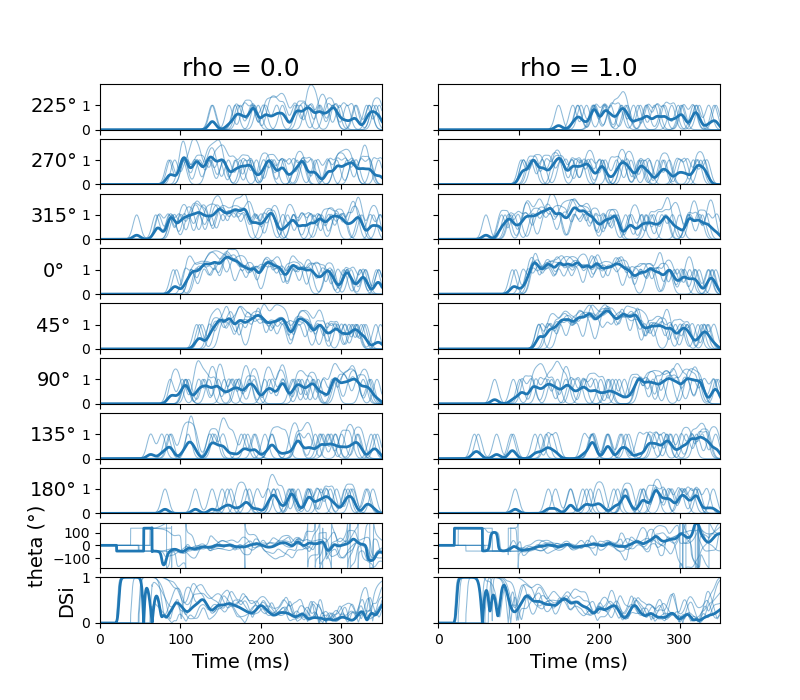

In [13]:
evol = time_evolution(d, dir_labels, kernel_var=45, figsize=(8, 7))

In [14]:
rho = 1.0
if d[rho][0]["params"]["soma_Na"] == 0.0:  # TTX condition
    rec_locs = d[rho][0]["dendrites"]["locs"]
    syn_locs = d[rho][0]["syn_locs"]
    syn_rec_lookups = get_syn_rec_lookups(rec_locs, syn_locs)
    post_syn_avg_tuning = get_postsyn_avg_tuning(tuning, syn_rec_lookups)
    theta_diffs = plot_theta_diff_tuning_scatters(post_syn_avg_tuning, sac_deltas, rhos=[rho])
    theta_diff_bins = plot_theta_diff_vs_abs_theta(post_syn_avg_tuning, sac_deltas, rhos=[rho])

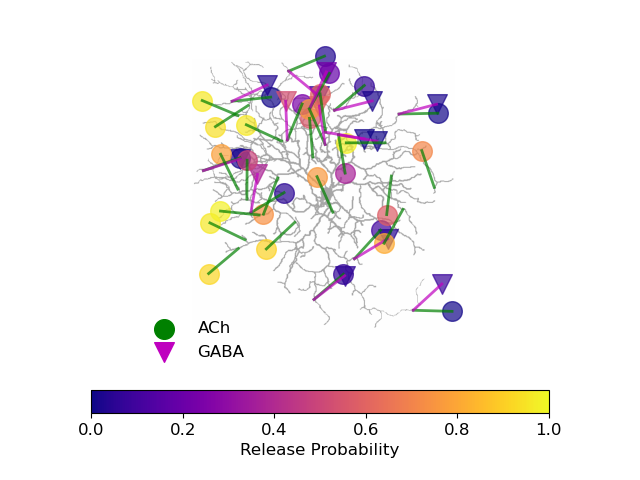

In [15]:
rho = 0.0
net = 0

over_fig, over_ax = plt.subplots(1)
ana.plot_dends_overlay(
    over_fig,
    over_ax,
    d[rho][net]["syn_locs"],
    d[rho][net]["sac_net"]["wiring"]["bp_locs"],
    d[rho][net]["sac_net"]["wiring"]["probs"],
    dir_labels,
    stim_angle=0,
    n_syn=30,
    sac_thickness=2,
    sac_marker_size=200,
    syn_choice_seed=6,
)
#6 26 37
over_fig.tight_layout()

Average GABA synapse count: 143.08


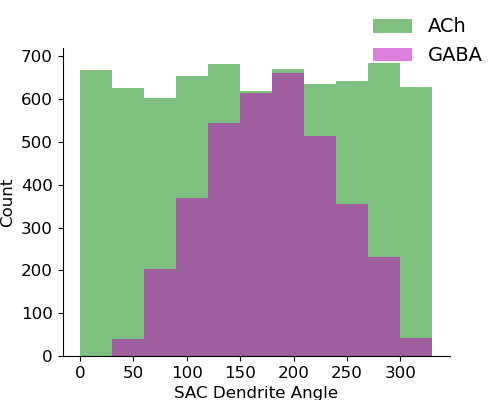

In [16]:
conf = copy.deepcopy(model_config)
conf["seed"] = 4
angle_dist_fig, angle_dist_ax = ana.sac_angle_distribution(
    conf, n_nets=25, bins=[12], incl_yticks=True, figsize=(5, 4))

/home/geoff/git/ei-balance/interactive.py:92: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  self.trial_slider = Slider(


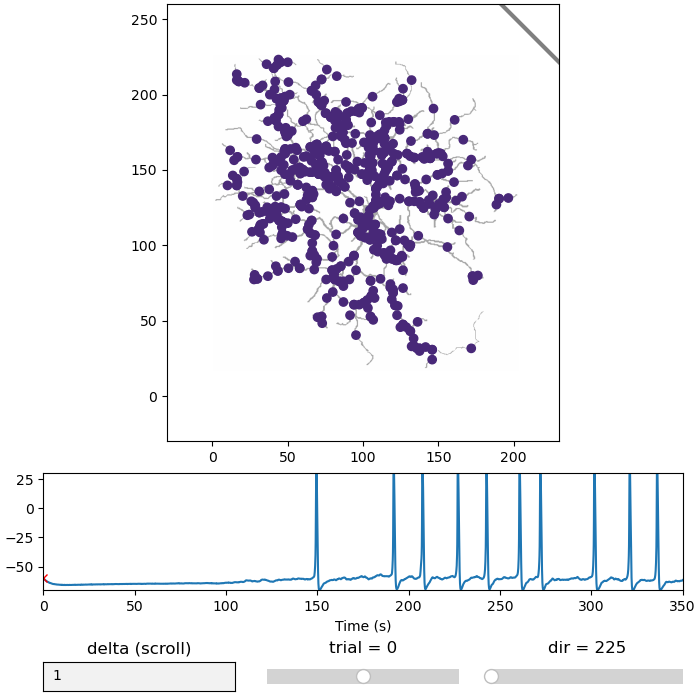

In [17]:
# mr = MotionResponse(d[0.0][0], tree_k="Vm", figsize=(7, 7))
mr = MotionResponse(d[1.0][0], tree_k="Vm", figsize=(7, 7))

In [18]:
close_button()

In [19]:
rng = np.random.default_rng()
rho = 0.6
rate = vrate * 1.25
scale = 0.6
base_total, e_total, i_total, corr = [], [], [], []
t0 = time.time()
for _ in range(10000):
    # I BASE
    # i_psn = deconv.poisson_of_release(rng, rate)
    # e_psn = np.round(scale * (i_psn * rho + deconv.poisson_of_release(rng, rate * np.sqrt(1 - rho**2)))).astype(int)
    # e_psn = np.round(scale * (i_psn * rho + deconv.poisson_of_release(rng, rate * (1 - rho)))).astype(int)
    # i_psn = np.round(scale * i_psn).astype(int)
    # SHARED BASE
    base_psn = deconv.poisson_of_release(rng, rate * rho)
    # e_psn = np.round(scale * (base_psn + deconv.poisson_of_release(rng, rate * np.sqrt(1 - rho**2)))).astype(int)
    # i_psn = np.round(scale * (base_psn + deconv.poisson_of_release(rng, rate * np.sqrt(1 - rho**2)))).astype(int)
    e_psn = np.round(scale * (base_psn + deconv.poisson_of_release(rng, rate * (1 - rho)))).astype(int)
    i_psn = np.round(scale * (base_psn + deconv.poisson_of_release(rng, rate * (1 - rho)))).astype(int)
    
    i_total.append(np.sum(i_psn))
    e_total.append(np.sum(e_psn))
    corr.append(np.corrcoef(i_psn, e_psn)[0][1])

print("time = %f" % (time.time() - t0))
print("i total = %f\ne total = %f\n corr = %f\n" % (np.mean(i_total), np.mean(e_total), np.mean(corr)))

time = 21.705083
i total = 77.435900
e total = 77.428700
 corr = 0.611771

